In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Literal
from scipy.optimize import minimize_scalar
from multiprocessing import Pool
from functools import partial

# System Description:

This is a simple spring loaded lever arm with a point mass at the far end representing the weapon. The distance between the base of the arm and the point mass is $r_w$, and the mass of the point mass is $m$. The distance between the base of the arm and the mounting point of the spring is $r_s$ and the spring constant is $k$. The other end of the spring is fixed relative to the base of the arm and is mounted at position $(x_s, y_s)$, letting the base of the arm be the origin.

The arm is free to rotate about the base, causing the spring to be stretched or compressed. The length of the spring in its uncompressed state is $l_0$. The length of the spring at any given angle $\theta$ is given in Equation 1.

\begin{equation}
    \tag{1}
    l(\theta) = \sqrt{(r_s \cos(\theta) - x_s)^2 + (r_s \sin(\theta) - y_s)^2}
\end{equation}

From Equation 1, it is possible to find the elastic potential energy stored in the spring at any given angle $\theta$. This is shown in Equation 2.

\begin{equation}
    \tag{2}
    U_s(\theta) = \frac{1}{2} k (l(\theta) - l_0)^2
\end{equation}

The gravitional potential energy of the point mass is given in Equation 3.

\begin{equation}
    \tag{3}
    U_g(\theta) = m g r_w \sin(\theta)
\end{equation}

Since both the gravitaional force and the spring force are conservitive, it is possible to find the approximate torque exerted on the arm at any given angle $\theta$ by taking the derivative of the total potential energy with respect to $\theta$. This is shown in Equation 4. Note that this is only an approximation, since there will also be a small torque due to changes in the angular velocity of the arm. However, this term will be so small as to be negligible.

\begin{equation}
    \tag{4}
    \tau(\theta) = -\frac{d}{d\theta} (U_s(\theta) + U_g(\theta))
\end{equation}

Substututing the in Equations 2 and 3 into Equation 4 and simplifying gives Equation 5.

\begin{equation}
    \tag{5}
    \tau(\theta) = - \left( kr_s \left( x_s \sin(\theta) - y_s \cos(\theta) \right) \frac{l(\theta) - l_0}{l(\theta)} + mgr_w \cos(\theta) \right)
\end{equation}

Ideally we would like the arm to impact the openent at a the angle $\theta_{impact}$ and be released from $\theta_{release}$, where $\tau(\theta_{impact}) = 0$ and $\tau(\theta_{release}) = 0$. These angles correspond to the points along the rotation of the arm at which the potential energy of the system is at its minimum and maximum energy, respectively. In this way the impact velocity of the weapon will be maximized, causing the greatest damage to the opponent. The linear velocity at $\theta_{impact}$ when released from $\theta_{release}$ is given in Equation 6.

\begin{equation}
    \tag{6}
    v_{impact} = \sqrt{\frac{2 \left(U_s(\theta_{release}) - U_s(\theta_{impact}) + U_g(\theta_{release}) - U_g(\theta_{impact}) \right)}{m}}
\end{equation}

In [2]:
class Springlock:
    # Helper variables to convert units
    _length_unit_conversins = {
        'm': 1.000,
        'cm': 1.000e-2,
        'mm': 1.000e-3,
        'ft': 0.3048,
        'in': 0.0254
    }

    _mass_unit_conversions = {
        'kg': 1.000,
        'g': 1.000e-3,
        'lb': 0.4536,
        'oz': 0.02835
    }

    _spring_constant_unit_conversions = {
        'N/m': 1.000,
        'lbf/in': 175.1
    }

    _speed_unit_conversions = {
        'm/s': 1.000,
        'ft/s': 0.3048,
        'mph': 0.4470
    }

    _torque_unit_conversions = {
        'N*m': 1.000,
        'lbf*ft': 1.356,
        'ozf*ft': 0.08474,
        'lbf*in': 0.1130,
        'ozf*in': 0.007062
    }

    _angle_unit_conversions = {
        'rad': 1.000,
        'deg': 0.01745
    }


    def __init__(self, weapon_radius: np.float64, weapon_mass: np.float64, spring_radius: np.float64, spring_constant: np.float64, spring_resting_length: np.float64, spring_mounting_point: Tuple[np.float64, np.float64],
                 *, length_units: Literal['m', 'cm', 'mm', 'ft', 'in'] = 'm', mass_units: Literal['kg', 'g', 'lb', 'oz'] = 'kg', spring_constant_units: Literal['N/m', 'lbf/in'] = 'N/m',
                    speed_units: Literal['m/s', 'ft/s', 'mph'] = 'm/s', torque_units: Literal['N*m', 'lbf*ft', 'ozf*ft', 'lbf*in', 'ozf*in'] = 'N*m', angle_units: Literal['rad', 'deg'] = 'rad'):
        
        """Creates a new Springlock object with the specified parameters.

        Args:
            weapon_radius (np.float64): The distance from the base of the arm to the center of the weapon.
            weapon_mass (np.float64): The mass of the weapon.
            spring_radius (np.float64): The distance from the base of the arm to the mounting point of the spring.
            spring_constant (np.float64): The spring constant of the springs. If multiple springs are used in parallel, this should be the sum of the sprting constants.
            spring_resting_length (np.float64): The length of the spring when it is not under any tension or compression.
            spring_mounting_point (Tuple[np.float64, np.float64]): The x and y coordinates of the fixed mounting point of the spring, relative to the base of the arm
        """
        

        self._length_scale = Springlock._length_unit_conversins[length_units]
        self._mass_scale = Springlock._mass_unit_conversions[mass_units]
        self._spring_constant_scale = Springlock._spring_constant_unit_conversions[spring_constant_units]
        self._speed_scale = Springlock._speed_unit_conversions[speed_units]
        self._torque_scale = Springlock._torque_unit_conversions[torque_units]
        self._angle_scale = Springlock._angle_unit_conversions[angle_units]

        # Class variables that will not be changed
        self._weapon_radius = weapon_radius * self._length_scale
        self._weapon_mass = weapon_mass * self._mass_scale
        self._spring_radius = spring_radius * self._length_scale
        self._spring_constant = spring_constant * self._spring_constant_scale
        self._spring_resting_length = spring_resting_length * self._length_scale
        self._spring_mounting_point = (spring_mounting_point[0] * self._length_scale, spring_mounting_point[1] * self._length_scale)

        self._length_units = length_units
        self._mass_units = mass_units
        self._spring_constant_units = spring_constant_units
        self._speed_units = speed_units
        self._torque_units = torque_units
        self._angle_units = angle_units

        # Class variables that will be calculated and memoized as needed
        self._max_theta = None
        self._min_theta = None
        self._max_torque_theta = None


    ############################
    ###### Getter Methods ######
    ############################
    @property
    def weapon_radius(self) -> np.float64:
        return self._weapon_radius / self._length_scale
    
    @property
    def weapon_mass(self) -> np.float64:
        return self._weapon_mass / self._mass_scale
    
    @property
    def spring_radius(self) -> np.float64:
        return self._spring_radius / self._length_scale
    
    @property
    def spring_constant(self) -> np.float64:
        return self._spring_constant / self._spring_constant_scale
    
    @property
    def spring_resting_length(self) -> np.float64:
        return self._spring_resting_length / self._length_scale
    
    @property
    def spring_mounting_point(self) -> Tuple[np.float64, np.float64]:
        return (self._spring_mounting_point[0] / self._length_scale, self._spring_mounting_point[1] / self._length_scale)
    
    @property
    def spring_mounting_point_x(self) -> np.float64:
        return self._spring_mounting_point[0] / self._length_scale
    
    @property
    def spring_mounting_point_y(self) -> np.float64:
        return self._spring_mounting_point[1] / self._length_scale
    
    @property
    def tip_to_spring(self) -> np.float64:
        return self.weapon_radius - self.spring_radius
    
    @property
    def max_theta(self) -> np.float64:
        if self._max_theta is None:
            self._max_theta = self._calculate_max_theta()
        return self._max_theta / self._angle_scale
    
    @property
    def release_angle(self) -> np.float64:
        return self.max_theta
    
    @property
    def max_potential_energy(self) -> np.float64:
        if self._max_theta is None:
            self._max_theta = self._calculate_max_theta()
        return self._total_potential_energy(self._max_theta)
    
    @property
    def min_theta(self) -> np.float64:
        if self._min_theta is None:
            self._min_theta = self._calculate_min_theta()
        return self._min_theta / self._angle_scale
    
    @property
    def impact_angle(self) -> np.float64:
        return self.min_theta
    
    @property
    def min_potential_energy(self) -> np.float64:
        if self._min_theta is None:
            self._min_theta = self._calculate_min_theta()
        return self._total_potential_energy(self._min_theta)
    
    @property
    def max_speed(self) -> np.float64:
        return (np.sqrt(2 * (self.max_potential_energy - self.min_potential_energy) / self._weapon_mass)) / self._speed_scale
    
    @property
    def max_torque_theta(self) -> np.float64:
        if self._max_torque_theta is None:
            self._max_torque_theta = self._calculate_max_torque_theta()
        return self._max_torque_theta / self._angle_scale
    
    @property
    def max_torque(self) -> np.float64:
        if self._max_torque_theta is None:
            self._max_torque_theta = self._calculate_max_torque_theta()
        return np.abs(self._torque(self._max_torque_theta)) / self._torque_scale
    

    ###################################
    ###### Unit conversion stuff ######
    ###################################

    @property
    def length_units(self) -> Literal['m', 'cm', 'mm', 'ft', 'in']:
        return self._length_units
    
    @length_units.setter
    def length_units(self, value: Literal['m', 'cm', 'mm', 'ft', 'in']):
        self._length_units = value
        self._length_scale = Springlock._length_unit_conversions[value]

    @property
    def mass_units(self) -> Literal['kg', 'g', 'lb', 'oz']:
        return self._mass_units
    
    @mass_units.setter
    def mass_units(self, value: Literal['kg', 'g', 'lb', 'oz']):
        self._mass_units = value
        self._mass_scale = Springlock._mass_unit_conversions[value]

    @property
    def spring_constant_units(self) -> Literal['N/m', 'lbf/in']:
        return self._spring_constant_units
    
    @spring_constant_units.setter
    def spring_constant_units(self, value: Literal['N/m', 'lbf/in']):
        self._spring_constant_units = value
        self._spring_constant_scale = Springlock._spring_constant_unit_conversions[value]

    @property
    def speed_units(self) -> Literal['m/s', 'ft/s', 'mph']:
        return self._speed_units
    
    @speed_units.setter
    def speed_units(self, value: Literal['m/s', 'ft/s', 'mph']):
        self._speed_units = value
        self._speed_scale = Springlock._speed_unit_conversions[value]

    @property
    def torque_units(self) -> Literal['N*m', 'lbf*ft', 'ozf*ft', 'lbf*in', 'ozf*in']:
        return self._torque_units
    
    @torque_units.setter
    def torque_units(self, value: Literal['N*m', 'lbf*ft', 'ozf*ft', 'lbf*in', 'ozf*in']):
        self._torque_units = value
        self._torque_scale = Springlock._torque_unit_conversions[value]

    @property
    def angle_units(self) -> Literal['rad', 'deg']:
        return self._angle_units
    
    @angle_units.setter
    def angle_units(self, value: Literal['rad', 'deg']):
        self._angle_units = value
        self._angle_scale = Springlock._angle_unit_conversions[value]

    @property
    def energy_units(self) -> Literal['J']:
        return 'J'
    

    #############################
    ###### Physics Methods ######
    #############################

    def spring_length(self, arm_angle: np.float64) -> np.float64:
        """Calculates the length of the spring at a given arm angle.

        Args:
            arm_angle (np.float64): The angle of the arm in radians.

        Returns:
            np.float64: The length of the spring.
        """
        return self._spring_length(arm_angle * self._angle_scale) / self._length_scale

    def _spring_length(self, arm_angle: np.float64) -> np.float64:
        """Calculates the length of the spring at a given arm angle.

        Args:
            arm_angle (np.float64): The angle of the arm in radians.

        Returns:
            np.float64: The length of the spring.
        """
        return np.sqrt((self._spring_mounting_point[0] - self._spring_radius * np.cos(arm_angle))**2 + (self._spring_mounting_point[1] + self._spring_radius * np.sin(arm_angle))**2)
    
    def spring_potential_energy(self, arm_angle: np.float64) -> np.float64:
        """Calculates the energy stored in the spring at a given arm angle.

        Args:
            arm_angle (np.float64): The angle of the arm in radians.

        Returns:
            np.float64: The energy stored in the spring.
        """
        return self._spring_potential_energy(arm_angle * self._angle_scale)
    
    def _spring_potential_energy(self, arm_angle: np.float64) -> np.float64:
        return 0.5 * self._spring_constant * (self._spring_length(arm_angle) - self._spring_resting_length)**2
    
    def gravitational_potential_energy(self, arm_angle: np.float64) -> np.float64:
        """Calculates the gravitational potential energy of the weapon at a given arm angle.

        Args:
            arm_angle (np.float64): The angle of the arm in radians.

        Returns:
            np.float64: The gravitational potential energy of the weapon.
        """
        return self._gravitational_potential_energy(arm_angle * self._angle_scale)
    
    def _gravitational_potential_energy(self, arm_angle: np.float64) -> np.float64:
        return self._weapon_mass * 9.81 * self._weapon_radius * np.sin(arm_angle)
    
    def total_potential_energy(self, arm_angle: np.float64) -> np.float64:
        """Calculates the total potential energy of the system at a given arm angle.

        Args:
            arm_angle (np.float64): The angle of the arm in radians.

        Returns:
            np.float64: The total potential energy of the system.
        """
        return self._total_potential_energy(arm_angle * self._angle_scale)
    
    def _total_potential_energy(self, arm_angle: np.float64) -> np.float64:
        return self._spring_potential_energy(arm_angle) + self._gravitational_potential_energy(arm_angle)
    
    def torque(self, arm_angle: np.float64) -> np.float64:
        """Calculates the torque on the arm at a given arm angle.

        Args:
            arm_angle (np.float64): The angle of the arm in radians.

        Returns:
            np.float64: The torque on the arm.
        """
        return self._torque(arm_angle * self._angle_scale) / self._torque_scale
    
    def _torque(self, arm_angle: np.float64) -> np.float64:
        spring_torque = self._spring_constant * self._spring_radius * (self._spring_mounting_point[0] * np.sin(arm_angle) - self._spring_mounting_point[1] * np.cos(arm_angle)) * (self._spring_length(arm_angle) - self._spring_resting_length) / self._spring_length(arm_angle)
        gravity_torque = self._weapon_mass * 9.81 * self._weapon_radius * np.cos(arm_angle)
        return -(spring_torque + gravity_torque)
    

    ############################
    ###### Helper Methods ######
    ############################

    def _calculate_max_theta(self) -> np.float64:
        """Calculates the angle of the arm at which the total potential energy of the system is maximized.

        Returns:
            np.float64: The maximum angle of the arm in radians.
        """
        optimize_results = minimize_scalar(lambda x: -self._total_potential_energy(x), bounds=(-np.pi, np.pi), method='bounded')

        if optimize_results.success:
            return optimize_results.x
        else:
            raise RuntimeError('Unable to find maximum potential energy of springlock system')
    
    def _calculate_min_theta(self) -> np.float64:
        """Calculates the angle of the arm at which the total potential energy of the system is minimized.

        Returns:
            np.float64: The minimum angle of the arm in radians.
        """
        optimize_results = minimize_scalar(lambda x: self._total_potential_energy(x), bounds=(-np.pi, np.pi), method='bounded')

        if optimize_results.success:
            return optimize_results.x
        else:
            raise RuntimeError('Unable to find minimum potential energy of springlock system')
        
    def _calculate_max_torque_theta(self) -> np.float64:
        """Calculates the maximum torque on the arm.

        Returns:
            np.float64: The maximum torque on the arm.
        """
        optimize_results = minimize_scalar(lambda x: -(self._torque(x) ** 2), bounds=(self._min_theta, self._max_theta), method='bounded')

        if optimize_results.success:
            return optimize_results.x
        else:
            raise RuntimeError('Unable to find maximum torque of springlock system')

# Optimization parameters

The following options are available for optimization:

- `min_weapon_mass`: The minimum mass of the weapon in pounds
- `max_weapon_mass`: The maximum mass of the weapon in pounds
- `min_weapon_radius`: The minimum length of the arm in inches
- `max_weapon_radius`: The maximum length of the arm in inches
- `min_spring_constant`: The minimum spring constant in pounds per inch
- `max_spring_constant`: The maximum spring constant in pounds per inch
- `min_spring_radius`: The minimum distance between the base of the arm and the spring
- `max_spring_radius`: The maximum distance between the base of the arm and the spring
- `min_tip_to_spring`: The minnumum distance that can be between the end of the arm and the spring mount point in inches
- `min_spring_resting_length`: The minimum resting length of the spring in inches
- `max_spring_resting_length`: The maximum resting length of the spring in inches
- `min_spring_mounting_point_x`: The minimum x coordinate of the spring mount wrt the base of the arm in inches
- `max_spring_mounting_point_x`: The maximum x coordinate of the spring mount wrt the base of the arm in inches
- `min_spring_mounting_point_y`: The minimum y coordinate of the spring mount wrt the base of the arm in inches
- `max_spring_mounting_point_y`: The maximum y coordinate of the spring mount wrt the base of the arm in inches
- `min_impact_angle`: The minimum angle at which the weapon can impact the opponent in degrees
- `max_impact_angle`: The maximum angle at which the weapon can impact the opponent in degrees
- `min_release_angle`: The minimum angle at which the weapon can be released in degrees
- `max_release_angle`: The maximum angle at which the weapon can be released in degrees


# Optimization objective


- `target_speed`: The target speed of the weapon at impact in mph. The optimization will attempt to find a set of system parameters that will result in the smallest maximum torque while still achieving the target speed.


In [3]:
# Minimum and maximum system parameters
min_weapon_mass = 3 # kg
max_weapon_mass = 5 # kg
min_weapon_radius = 0.2 # m
max_weapon_radius = 0.4 # m
min_spring_constant = 1 # N/m
max_spring_constant = 1e6 # N/m
min_spring_radius = 0.01 # m
max_spring_radius = 0.6 # m
min_tip_to_spring = 0.15 # m
min_spring_resting_length = 0.01 # m
max_spring_resting_length = 0.6 # m
min_spring_mounting_point_x = -0.15 # m
max_spring_mounting_point_x = 0.15 # m
min_spring_mounting_point_y = -0.10 # m
max_spring_mounting_point_y = 0.10 # m
min_impact_angle = -15 # degrees
max_impact_angle = 15 # degrees
min_release_angle = 60 # degrees
max_release_angle = 120 # degrees

target_speed = 10 # m/s

# EA Code

In [4]:
# EA parameters
population_size = 1000
max_generations = 1000
mutation_rate = 0.9
mutation_scale = 0.25
termination_precision = 1e-6
genome_size = 7
viable_population_ratio = 0.5 # The top 50% of the population will be selected for reproduction
fitness_exponent = 1.01 # Each specimen will have 1/n the chance of the next most fit specimen of being selected for reproduction

genome_mapping = [
    'weapon_mass',
    'weapon_radius',
    'spring_constant',
    'spring_radius',
    'spring_resting_length',
    'spring_mounting_point'
]

genome_ranges = [
    (min_weapon_mass, max_weapon_mass),
    (min_weapon_radius, max_weapon_radius),
    (min_spring_constant, max_spring_constant),
    (min_spring_radius, max_spring_radius),
    (min_spring_resting_length, max_spring_resting_length),
    (min_spring_mounting_point_x, max_spring_mounting_point_x),
    (min_spring_mounting_point_y, max_spring_mounting_point_y)
]

In [5]:
def fitness(genome):
    genome = [*genome[:-2], (genome[-2], genome[-1])]
    genome_dict = dict(zip(genome_mapping, genome))
    springlock = Springlock(**genome_dict, angle_units='deg')

    # If all the values are within the bounds, the fitness is one over the torque
    # Otherwise, the fitness is the negative sum of how bad all the violations are
    fitness = None

    if springlock.weapon_mass < min_weapon_mass or springlock.weapon_mass > max_weapon_mass:
        if fitness is None:
            fitness = 0
        fitness -= np.abs(springlock.weapon_mass - (min_weapon_mass + max_weapon_mass) / 2) / ((max_weapon_mass - min_weapon_mass) / 2)

    if springlock.weapon_radius < min_weapon_radius or springlock.weapon_radius > max_weapon_radius:
        if fitness is None:
            fitness = 0
        fitness -= np.abs(springlock.weapon_radius - (min_weapon_radius + max_weapon_radius) / 2) / ((max_weapon_radius - min_weapon_radius) / 2)

    if springlock.spring_constant < min_spring_constant or springlock.spring_constant > max_spring_constant:
        if fitness is None:
            fitness = 0
        fitness -= np.abs(springlock.spring_constant - (min_spring_constant + max_spring_constant) / 2) / ((max_spring_constant - min_spring_constant) / 2)

    if springlock.spring_radius < min_spring_radius or springlock.spring_radius > max_spring_radius:
        if fitness is None:
            fitness = 0
        fitness -= np.abs(springlock.spring_radius - (min_spring_radius + max_spring_radius) / 2) / ((max_spring_radius - min_spring_radius) / 2)

    if springlock.tip_to_spring < min_tip_to_spring:
        if fitness is None:
            fitness = 0
        fitness -= np.abs(springlock.tip_to_spring - min_tip_to_spring) / min_tip_to_spring

    if springlock.spring_resting_length < min_spring_resting_length or springlock.spring_resting_length > max_spring_resting_length:
        if fitness is None:
            fitness = 0
        fitness -= np.abs(springlock.spring_resting_length - (min_spring_resting_length + max_spring_resting_length) / 2) / ((max_spring_resting_length - min_spring_resting_length) / 2)

    if springlock.spring_mounting_point[0] < min_spring_mounting_point_x or springlock.spring_mounting_point[0] > max_spring_mounting_point_x:
        if fitness is None:
            fitness = 0
        fitness -= np.abs(springlock.spring_mounting_point[0] - (min_spring_mounting_point_x + max_spring_mounting_point_x) / 2) / ((max_spring_mounting_point_x - min_spring_mounting_point_x) / 2)

    if springlock.spring_mounting_point[1] < min_spring_mounting_point_y or springlock.spring_mounting_point[1] > max_spring_mounting_point_y:
        if fitness is None:
            fitness = 0
        fitness -= np.abs(springlock.spring_mounting_point[1] - (min_spring_mounting_point_y + max_spring_mounting_point_y) / 2) / ((max_spring_mounting_point_y - min_spring_mounting_point_y) / 2)

    if springlock.impact_angle < min_impact_angle or springlock.impact_angle > max_impact_angle:
        if fitness is None:
            fitness = 0
        fitness -= np.abs(springlock.impact_angle - (min_impact_angle + max_impact_angle) / 2) / ((max_impact_angle - min_impact_angle) / 2)

    if springlock.release_angle < min_release_angle or springlock.release_angle > max_release_angle:
        if fitness is None:
            fitness = 0
        fitness -= np.abs(springlock.release_angle - (min_release_angle + max_release_angle) / 2) / ((max_release_angle - min_release_angle) / 2)

    if springlock.max_speed < target_speed:
        if fitness is None:
            fitness = 0
        fitness -= 100 * np.abs(springlock.max_speed - target_speed) / target_speed

    if fitness is None:
        fitness = 1 / abs(springlock.max_torque)

    return fitness


def evaluate_population(population):
    with Pool() as pool:
        fitnesses = pool.map(fitness, population)        
    population, fitnesses = zip(*sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True))
    return list(population), list(fitnesses)


def parent_selection(population):
    population, _ = evaluate_population(population)
    return population[:int(len(population) * viable_population_ratio)]

def create_child(parents):
    max_rand = (1 / fitness_exponent) ** (len(parents) - 1)
    parent_1_idx = int(np.log(np.random.uniform(low=0, high=max_rand)) / np.log(1 / fitness_exponent))
    parent_2_idx = int(np.log(np.random.uniform(low=0, high=max_rand)) / np.log(1 / fitness_exponent))

    parent_1 = parents[min(len(parents) - 1, parent_1_idx)]
    parent_2 = parents[min(len(parents) - 1, parent_2_idx)]

    child = []

    for i in range(len(parent_1)):
        if np.random.rand() < 0.5:
            child.append(parent_1[i])
        else:
            child.append(parent_2[i])

    for i in range(len(child)):
        if np.random.rand() < mutation_rate:
            mutation_magnitude = (np.random.rand() * 2 * mutation_scale - mutation_scale) * child[i]
            child[i] += mutation_magnitude

            child[i] = max(child[i], genome_ranges[i][0])
            child[i] = min(child[i], genome_ranges[i][1])

    return child


def crossover(parents):
    # return [create_child(parents) for _ in range(population_size)]
    with Pool() as pool:
        # create a partial function that has the parents argument already filled in
        children = pool.map(create_child, [parents] * population_size)

    return children


def survivor_selection(population, children):
    population, fitnesses = evaluate_population(population + children)
    return population[:population_size], fitnesses[:population_size]

In [6]:
# Initialize the population
population = [
    [np.random.uniform(high=genome_ranges[i][1], low=genome_ranges[i][0]) for i in range(genome_size)]
    for _ in range(population_size)
]

# Run the genetic algorithm
for generation in range(1, max_generations + 1):
    parents = parent_selection(population)
    children = crossover(parents)
    population, fitnesses = survivor_selection(parents, children)

    best_fitness = max(fitnesses)
    average_fitness = sum(fitnesses) / len(fitnesses)

    print(f"Generation {generation:4d} | Best fitness: {best_fitness:10.4f} | Average fitness: {average_fitness:10.4f}")

Generation    1 | Best fitness:    -1.2372 | Average fitness:    -5.4218
Generation    2 | Best fitness:     0.0022 | Average fitness:    -3.2564
Generation    3 | Best fitness:     0.0044 | Average fitness:    -1.3744
Generation    4 | Best fitness:     0.0080 | Average fitness:    -0.7784
Generation    5 | Best fitness:     0.0107 | Average fitness:    -0.7166
Generation    6 | Best fitness:     0.0140 | Average fitness:    -0.7287
Generation    7 | Best fitness:     0.0140 | Average fitness:    -0.6484
Generation    8 | Best fitness:     0.0148 | Average fitness:    -0.4984
Generation    9 | Best fitness:     0.0148 | Average fitness:    -1.0623
Generation   10 | Best fitness:     0.0161 | Average fitness:    -1.1271
Generation   11 | Best fitness:     0.0161 | Average fitness:    -1.0818
Generation   12 | Best fitness:     0.0161 | Average fitness:    -1.2370
Generation   13 | Best fitness:     0.0161 | Average fitness:    -1.2534
Generation   14 | Best fitness:     0.0161 | Averag

In [12]:
# print out the best genome
population, fitnesses = evaluate_population(population)

best_genome = population[0]
best_fitness = fitnesses[0]

print(f"Best genome: {best_genome}")
print(f"Best fitness: {best_fitness}")

# Run the simulation with the best genome
genome = [*best_genome[:-2], (best_genome[-2], best_genome[-1])]
genome_dict = dict(zip(genome_mapping, genome))
print(genome_dict)
springlock = Springlock(**genome_dict, angle_units='deg')
springlock.angle_units = 'deg'
springlock.torque_units = 'ozf*in'
print(f'Impact speed is {springlock.max_speed:.2f} {springlock.speed_units}')
print(f'Impact angle is {springlock.impact_angle:.2f} {springlock.angle_units}')
print(f'Release angle is {springlock.release_angle:.2f} {springlock.angle_units}')
print(f'Maximum torque is {springlock.max_torque:.2f} {springlock.torque_units}')
print(f'Maximum torque is at {springlock.max_torque_theta:.2f} {springlock.angle_units}')
print(f'Spring constant is {springlock.spring_constant:.2f} {springlock.spring_constant_units}')
print(f'Stored energy is {springlock.max_potential_energy:.2f} {springlock.energy_units}')

Best genome: [3, 0.4, 114211.96494379424, 0.04875360423932905, 0.056257193587311606, 0.02116991721547297, 0.05710932818817068]
Best fitness: 0.016050287455557356
{'weapon_mass': 3, 'weapon_radius': 0.4, 'spring_constant': 114211.96494379424, 'spring_radius': 0.04875360423932905, 'spring_resting_length': 0.056257193587311606, 'spring_mounting_point': (0.02116991721547297, 0.05710932818817068)}
Impact speed is 10.83 m/s
Impact angle is -11.82 deg
Release angle is 109.03 deg
Maximum torque is 8822.46 ozf*in
Maximum torque is at 26.04 deg
Spring constant is 114211.96 N/m
Stored energy is 173.95 J


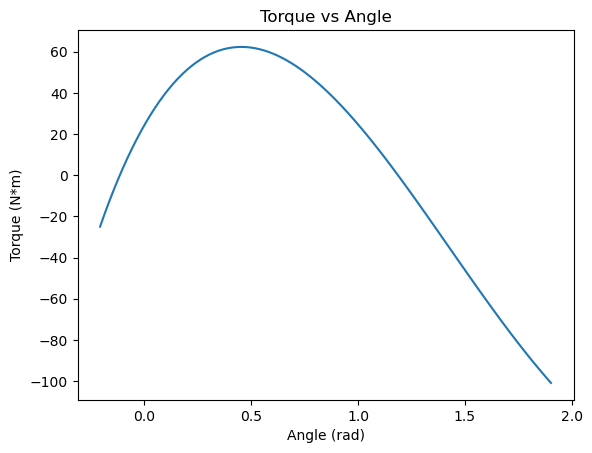

In [8]:
# Create a plot of the torque vs angle from the release angle to the impact angle
angles = np.linspace(springlock.release_angle, springlock.impact_angle, 100)
torques = [springlock.torque(angle) for angle in angles]

plt.plot(angles, torques)
plt.xlabel(f'Angle ({springlock.angle_units})')
plt.ylabel(f'Torque ({springlock.torque_units})')
plt.title('Torque vs Angle')
plt.show()

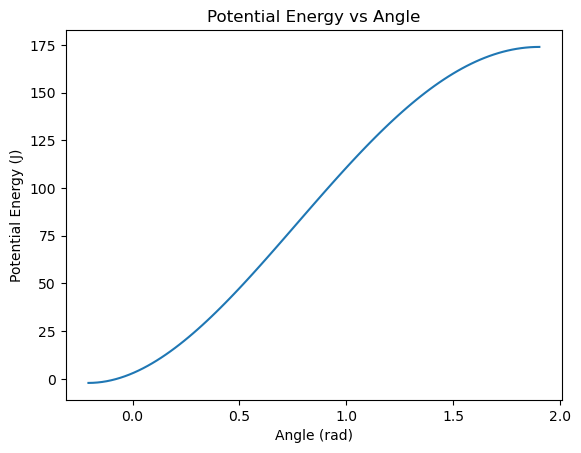

In [9]:
# Create a plot of the potential energy vs angle from the release angle to the impact angle
angles = np.linspace(springlock.release_angle, springlock.impact_angle, 100)
energies = [springlock.total_potential_energy(angle) for angle in angles]

plt.plot(angles, energies)
plt.xlabel(f'Angle ({springlock.angle_units})')
plt.ylabel(f'Potential Energy ({springlock.energy_units})')
plt.title('Potential Energy vs Angle')
plt.show()

In [10]:
# Find the angle at which the spring is at rest
minimize_scalar(springlock.spring_potential_energy, bounds=(min(springlock.release_angle, springlock.impact_angle), max(springlock.release_angle, springlock.impact_angle)), method='bounded')

 message: Solution found.
 success: True
  status: 0
     fun: 2.3153720740527467e-10
       x: -0.15935417796960347
     nit: 12
    nfev: 12

In [11]:
# Plot the percentage of the population that has a fitness greater than x, from the best to the worst
population, fitnesses = evaluate_population(population)
max_fitness = fitnesses[0]
min_fitness = fitnesses[-1]

fitness_measurements = np.linspace(min_fitness, max_fitness, 100)

NameError: name 'fitness_meas' is not defined